<code>Plot_JJA_VRILE_Count_vs_Sept_15_SIE.ipynb</code>

1. Load JJA VRILE ONLY days for each model AND obs
    *  Pick VRILE threshhold
    *  Pick Common Reforecast or not
2. Calculate number of VRILE days during JJA for each year
3. Load SIE for each model and obs
4. Calculate Sept 15 SIE for each model + obs
5. Calculate regression coef for # VRILE days on Sept 15 SIE using leave one out cross validation

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob2
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut  
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from scipy import signal 
import seaborn as sns

Load model data for common reforecast period

In [2]:
def load_model(model_name):
    # Paths for perturb and control runs
    filepath = '/home/disk/sipn/nicway/data/model/{model_name}/reforecast/sipn_nc_agg/'.format(model_name=model_name)
    filepath_ctrl = '/home/disk/sipn/nicway/data/model/{model_name}/reforecast.control/sipn_nc_agg/'.format(model_name=model_name)
    # Open both with xarray
    filenames = xr.open_mfdataset(filepath+'/*.nc',combine='by_coords')
    filenames_ctrl = xr.open_mfdataset(filepath_ctrl+'/*.nc',combine='by_coords')
    print(filenames)
    # load SIE
    SIE = filenames.Extent
    SIE_ctrl = filenames_ctrl.Extent
    # Add coordinate to ensemble dimension for SIE_ctrl so we can combine with SIE
    SIE_ctrl.coords['ensemble'] = xr.DataArray([len(SIE.ensemble)],
                                               dims='ensemble', coords={'ensemble':[len(SIE.ensemble)]})
    # Use common reforecast period for all models EXCEPT NCEP
    if model_name == 'ncep':
        # Don't need to use a common reforecast but remove repeated indices
        _,init_ind = np.unique(SIE['init_time'],return_index=True)
        _,init_ind_c = np.unique(SIE_ctrl['init_time'],return_index=True)
        SIE = SIE.isel(init_time=init_ind)
        SIE_ctrl = SIE_ctrl.isel(init_time=init_ind_c)
    elif model_name != 'ncep':
        common_start = '1999-01-01'
        common_end = '2014-12-31'
        # Select only common reforecast period (full period for NCEP)
        SIE = SIE.sel(init_time=slice(common_start,common_end))
        SIE_ctrl = SIE_ctrl.sel(init_time=slice(common_start,common_end))
        # Remove repeated indices in CTRL
        _,init_ind_c = np.unique(SIE_ctrl['init_time'],return_index=True)
        SIE_ctrl = SIE_ctrl.isel(init_time=init_ind_c)
    # Concatenate the two
    SIE = xr.concat([SIE,SIE_ctrl],dim='ensemble')
    
    return SIE

We want to create a few aggregate regions from the NSIDC MASIE regions (more at: https://nsidc.org/data/masie/browse_regions) since some regions are so small. We're going to combine the following: <br>
<li> Kara and Laptev Seas (<code>region_KL</code>)</li>
<li> Barents, Kara and Laptev Seas (<code>region_BKL</code>)</li>
<li> East Siberian, Beaufort, and Chukchi Seas (<code>region_EBC</code>)</li>
<li> Atlantic (Baffin Bay and East Greenland Sea) (<code>region_ATL</code>)</li>
<li> East Siberian, Beaufort, Chukchi, Laptev Seas (<code>region_EBCL</code>)</li>


In [3]:
def create_aggregate_regions(SIE_data):
    nregions = SIE_data['nregions']
    region_names = SIE_data['region_names']
    # Get corresponding indices for each of our aggregate regions
    region_KL = nregions[region_names.isin(['Kara Sea','Laptev Sea'])]
    region_BKL = nregions[region_names.isin(['Barents Sea','Kara Sea','Laptev Sea'])]
    region_EBC = nregions[region_names.isin(['East Siberian Sea','Beaufort Sea','Chukchi Sea'])]
    region_ATL = nregions[region_names.isin(['Baffin Bay','East Greenland Sea'])]
    region_EBCL = nregions[region_names.isin(['East Siberian Sea','Beaufort Sea','Chukchi Sea','Laptev Sea'])]
    # Select each aggregate region, add them together, and add the 'nregions' dimension back; concatenate all aggregates 
    SIE_agg = xr.concat([SIE_data.sel(nregions=region_KL).sum(dim='nregions').expand_dims(dim='nregions'),
                  SIE_data.sel(nregions=region_BKL).sum(dim='nregions').expand_dims(dim='nregions'),
                  SIE_data.sel(nregions=region_EBC).sum(dim='nregions').expand_dims(dim='nregions'),
                  SIE_data.sel(nregions=region_ATL).sum(dim='nregions').expand_dims(dim='nregions'),
                  SIE_data.sel(nregions=region_EBCL).sum(dim='nregions').expand_dims(dim='nregions')],dim='nregions')
    # Add coordinates to nregions.  Start at 20 to make a clear separation from original NSIDC regions
    SIE_agg = SIE_agg.assign_coords(nregions=[20,21,22,23,24])
    # Add region names
    region_names_extra = ['Kara-Laptev Sea','Barents-Kara-Laptev Sea','East Siberian-Beaufort-Chukchi Sea',
                      'Atlantic','East Siberian-Beaufort-Chukchi-Laptev Sea']
    SIE_agg["region_names"] = ("nregions",region_names_extra)
    #SIE
    SIE_data = xr.concat([SIE_data,SIE_agg],dim='nregions')
    return(SIE_data)

Create Leave One Out regression

In [4]:
def regress_LOO_VRILE_count_on_SIE(VRILE_count,SIE_data):
    # Set up LeaveOneOut problem
    loo = LeaveOneOut()
    loo.get_n_splits(SIE_data)
    # Create X and y
    X = VRILE_count
    X = X.fillna(0)
    y = SIE_data
    y_test_vals = []
    y_pred_vals = []
    corr_coef = []
    # Do linear least squares regression
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # Add ones for regression
        X_train = pd.concat([X_train,pd.Series(np.ones(len(X)-1),index=X_train.index)],axis=1).dropna()
        X_test = pd.concat([X_test,pd.Series(np.ones(1),index=X_test.index)],axis=1).dropna()
        model = LinearRegression()
        model.fit(X = X_train, y = y_train)
        y_pred = model.predict(X_test)
        # save
        y_pred_vals += list(y_pred)
        y_test_vals += list(y_test.values)
        # Calculate the correlation too (just a sanity check)
        corr_vals = np.corrcoef(y_train,X_train.iloc[:,0])
        corr_coef = np.append(corr_coef,corr_vals[0,1])
    #return y_pred_vals, y_test_vals
    # Calculate MSE and R2
    r2 = metrics.r2_score(y_test_vals, y_pred_vals)
    rmse = metrics.mean_squared_error(y_test_vals,y_pred_vals,squared=False)
    # Corr coef
    straight_corr2 = np.mean(corr_coef[1::]**2)
    straight_corr = np.mean(corr_coef[1::])
    return pd.Series({'r2':r2,'rmse':rmse,'corr':straight_corr,'corr_sq':straight_corr2})

In [5]:
model_names_all = ['ecmwf','ukmo','ncep','metreofr']
seas_str = 'JJA'
seas_sel = [6,7,8]
obs_name = 'NSIDC_0079'
clim_freq_str = 'WEEKLY'
vrile_thresh = 0.05
thresh_str = '05'
nday_change = 5 #number of days for VRILE calculation
week_length = 7
COMMON_REFORECAST = False

Load model VRILE only

In [6]:
SIE_only_VRILE = pd.DataFrame()
for model_name in model_names_all:
    fpath_load = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/data/{model_name}/'.format(model_name=model_name)
    if COMMON_REFORECAST == True:
        fpath_load = fpath_load+'COMMON_REFORECAST/'
    vrile_load_name = fpath_load+'VRILE_count_SIE_{model_name}_months{seas_str}_VRILE{thresh_str}_model_clim_freq_{clim_freq_str}.csv'.format(model_name=model_name,
                                             seas_str=seas_str,thresh_str=thresh_str,clim_freq_str=clim_freq_str)
    SIE_load = pd.read_csv(vrile_load_name)
    SIE_load['model name'] = model_name
    SIE_only_VRILE = SIE_only_VRILE.append(SIE_load)

Add a valid year, and trim to only JJA

In [7]:
SIE_only_VRILE['valid year'] = pd.to_datetime(SIE_only_VRILE['valid date']).dt.year
SIE_JJA_VRILE = SIE_only_VRILE[SIE_only_VRILE['valid date month'].isin(seas_sel)]

Calculate number of VRILE days per year as a function of model name, region, lead week

In [8]:
SIE_VRILE_count = SIE_JJA_VRILE.groupby(['region','model name','lead weeks','valid year'])['SIE'].count()

Calculate SIE on Sept 15 for each year in each model 

In [9]:
SIE_sept_all_df = pd.DataFrame()
for imodel_name in model_names_all:
    SIE = load_model(imodel_name)
    print('loaded ',imodel_name)
    # Regions 
    SIE = create_aggregate_regions(SIE)
    print('combined regions')
    # Ensemble mean
    SIE_ens_mean = SIE.mean(dim='ensemble')
    regions = SIE.region_names
    lead_days = SIE.fore_time.dt.days
    # Data frame
    SIE_df = SIE_ens_mean.to_dataframe().reset_index()
    SIE_df['valid date'] = SIE_df['init_time'] + SIE_df['fore_time']
    SIE_df['model name'] = imodel_name        
    SIE_df = SIE_df.rename(columns={'region_names':'region',
                           'fore_time':'lead time (days)',
                           'init_time':'init date',
                           'Extent':'SIE'})
    # Lead time in weeks
    SIE_df['lead time (weeks)'] = SIE_df['lead time (days)'].values.astype('timedelta64[D]')/pd.Timedelta(week_length,'D')
    SIE_df['lead time (weeks)'] = SIE_df['lead time (weeks)'].apply(np.floor)
    # Keep only September SIE
    SIE_df['valid date month'] = pd.to_datetime(SIE_df['valid date']).dt.month
    SIE_df['valid year'] = pd.to_datetime(SIE_df['valid date']).dt.year

    SIE_df_Sept = SIE_df.where(SIE_df['valid date month']==9).dropna(how='all')
    SIE_sept_all_df = SIE_sept_all_df.append(SIE_df_Sept)
    

<xarray.Dataset>
Dimensions:       (ensemble: 10, fore_time: 46, init_time: 2080, nregions: 15)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * ensemble      (ensemble) int32 0 1 2 3 4 5 6 7 8 9
  * fore_time     (fore_time) timedelta64[ns] 0 days 1 days ... 44 days 45 days
  * init_time     (init_time) datetime64[ns] 1998-08-06 ... 2018-08-01
Data variables:
    Extent        (ensemble, init_time, fore_time, nregions) float64 dask.array<chunksize=(10, 1, 46, 15), meta=np.ndarray>
loaded  ecmwf
combined regions
<xarray.Dataset>
Dimensions:       (ensemble: 6, fore_time: 60, init_time: 1008, nregions: 15)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * ensemble      (ensemble) int32 0 1 2 3 4 5
  * fore_time     (fore_time) timedelta64[ns] 0 days 

Group by region, model name, lead time, and year to get Sept 15 SIE

In [10]:
SIE_sept_gb = SIE_sept_all_df.groupby(['region','model name',
                                       'lead time (weeks)','valid year',pd.to_datetime(SIE_sept_all_df['valid date']).dt.day]).mean()

SIE_sept_15 = SIE_sept_gb.xs(15,level=4)
SIE_sept_mean = SIE_sept_gb.min(level=(0,1,2,3))
regions_list = SIE_df_Sept['region'].unique().tolist()
SIE_sept_all_df['model name'].unique().tolist()

['ecmwf', 'ukmo', 'ncep', 'metreofr']

Use number of JJA VRILE Days to predict Sept 15 SIE as a function of region, lead time, and model

In [11]:
comb = pd.DataFrame(columns={'VRILE count','Sept SIE'})
#
comb['Sept SIE'] = SIE_sept_15['SIE']
comb['VRILE count'] = SIE_VRILE_count
comb = comb.fillna(0)
#SIE_VRILE_count
#comb

In [25]:
comb.loc['panArctic',:,0]

VRILE count  Sept SIE
region    model name lead time (weeks) valid year                       
panArctic ecmwf      0.0               1999.0              8.0  5.446354
                                       2000.0              6.0  5.796648
                                       2001.0              1.0  6.229254
                                       2002.0              3.0  5.351811
                                       2003.0              2.0  5.742722
                                       2004.0              0.0  5.485599
                                       2005.0             12.0  4.996584
                                       2006.0              2.0  5.311058
                                       2007.0             13.0  3.706599
                                       2008.0              3.0  4.309195
                                       2009.0             12.0  4.786190
                                       2010.0             11.0  4.333644
                                       2011.0             13.0  4.037906
                                       2012.0             27.0  3.158947
                                       2013.0             20.0  4.664224
                                       2014.0             13.0  4.717314
          metreofr   0.0               1999.0              0.0  5.913072
                                       2000.0              0.0  5.837602
                                       2001.0              0.0  6.355388
                                       2002.0              0.0  5.562446
                                       2003.0              0.0  5.486843
                                       2004.0              0.0  6.063971
                                       2005.0              0.0  5.188558
                                       2006.0              0.0  5.040087
                                       2007.0              9.0  4.289890
                                       2008.0              6.0  4.663524
                                       2009.0              5.0  4.593111
                                       2010.0              0.0  4.267769
                                       2011.0             12.0  3.888761
                                       2012.0             17.0  1.816398
                                       2013.0              6.0  3.786049
                                       2014.0             13.0  3.154293
          ncep       0.0               1999.0              9.0  6.413696
                                       2000.0              7.0  6.476580
                                       2001.0              2.0  7.044436
                                       2002.0             13.0  5.882300
                                       2003.0             16.0  6.254671
                                       2004.0             25.0  6.172196
                                       2005.0             80.0  5.935287
                                       2006.0             21.0  5.986774
                                       2007.0             32.0  4.278766
                                       2008.0             20.0  4.783804
                                       2009.0             80.0  5.647647
                                       2010.0             27.0  5.305069
          ukmo       0.0               1999.0              3.0  6.301736
                                       2000.0              7.0  6.550491
                                       2001.0              0.0  6.842221
                                       2002.0              9.0  6.091460
                                       2003.0              3.0  6.342100
                                       2004.0              8.0  6.093595
                                       2005.0             14.0  5.648623
                                       2006.0              0.0  6.012687
                                       2007.0             11.0  4.450984
                                    

In [13]:
#reg_sel = 'East Greenland Sea'
lead_sel = 0
SIE_R2 = pd.DataFrame(columns={'region','lead time (weeks)','R2','RMSE','model name','corr coef','corr coef sq'})
#SIE_R2['region'] = regions_list
#weeks_lead = SIE_df['lead time (weeks)'].unique().tolist()
#SIE_R2 = SIE_R2.set_index('region',weeks_lead)
for reg_sel in regions_list:
    print(reg_sel)
    for model_sel in model_names_all:
        print(model_sel)
        SIE_rx = pd.DataFrame(columns={'region','lead time (weeks)','R2','RMSE','model name'})
        comb_sel = comb.xs((reg_sel,model_sel,lead_sel))
        model_loo = regress_LOO_VRILE_count_on_SIE(comb_sel['VRILE count'],comb_sel['Sept SIE'])
        SIE_rx['lead time (weeks)'] = pd.Series(lead_sel)
        SIE_rx['region'] = pd.Series(reg_sel)
        SIE_rx['model name'] = pd.Series(model_sel)
        SIE_rx['R2'] = pd.Series(model_loo['r2'])
        SIE_rx['RMSE'] = pd.Series(model_loo['rmse'])
        SIE_rx['corr coef'] = pd.Series(model_loo['corr'])
        SIE_rx['corr coef sq'] = pd.Series(model_loo['corr_sq'])
        SIE_R2 = SIE_R2.append(SIE_rx)
    

panArctic
ecmwf
ukmo
ncep
metreofr
Sea of Okhotsk
ecmwf


/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divid

ukmo
ncep
metreofr


/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divid

Bering
ecmwf
ukmo
ncep


/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divid

metreofr
Hudson Bay
ecmwf
ukmo

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divid


ncep
metreofr


/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divid

St John
ecmwf
ukmo
ncep

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divid


metreofr
Baffin Bay
ecmwf


/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divid

ukmo
ncep
metreofr
East Greenland Sea
ecmwf
ukmo
ncep
metreofr
Barents Sea
ecmwf
ukmo
ncep
metreofr
Kara Sea
ecmwf
ukmo
ncep
metreofr
Laptev Sea
ecmwf
ukmo
ncep
metreofr
East Siberian Sea
ecmwf
ukmo
ncep
metreofr
Chukchi Sea
ecmwf
ukmo
ncep
metreofr
Beaufort Sea
ecmwf
ukmo
ncep
metreofr
Canadian Islands
ecmwf
ukmo
ncep
metreofr
Central Arctic
ecmwf
ukmo
ncep
metreofr
Kara-Laptev Sea
ecmwf
ukmo
ncep
metreofr
Barents-Kara-Laptev Sea
ecmwf
ukmo
ncep
metreofr
East Siberian-Beaufort-Chukchi Sea
ecmwf
ukmo
ncep
metreofr
Atlantic
ecmwf
ukmo
ncep
metreofr
East Siberian-Beaufort-Chukchi-Laptev Sea
ecmwf
ukmo
ncep
metreofr


In [30]:
SIE_R2 = SIE_R2.rename(columns={'region':'Region','model name':'Model Name'})
model_R2 = SIE_R2.groupby(['Region','Model Name'])['R2','RMSE','corr coef','corr coef sq'].mean()
model_R2.xs('panArctic')

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,R2,RMSE,corr coef,corr coef sq
Model Name,,,,
ecmwf,0.468285,0.584167,-0.763133,0.583916
metreofr,0.722334,0.612504,-0.889724,0.792059
ncep,-0.263706,0.819358,-0.310032,0.099851
ukmo,-0.222327,1.055933,0.196447,0.042390


Load obs

In [31]:
obs_load = fpath_load+'VRILE_count_SIE_obs_months{seas_str}_VRILE{thresh_str}_model_clim_freq_{clim_freq_str}.csv'.format(
                                             seas_str=seas_str,thresh_str=thresh_str,clim_freq_str=clim_freq_str)
obs_VRILE = pd.read_csv(obs_load)

In [32]:
obs_VRILE_JJA = obs_VRILE[obs_VRILE['valid date month'].isin(seas_sel)]
obs_VRILE_JJA['valid year'] = pd.to_datetime(obs_VRILE_JJA['valid date']).dt.year
obs_VRILE_count = obs_VRILE_JJA.groupby(['region','valid year'])['SIE'].count()

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Get obs Sept 15 SIE

In [33]:
obs_type = 'sipn_nc_yearly_agg'
filepath = '/home/disk/sipn/nicway/data/obs/{model_name}/{model_type}/'.format(model_name=obs_name,
                                                                              model_type=obs_type)
obs_filenames = xr.open_mfdataset(filepath+'/*.nc',combine='by_coords')
print('opening ',obs_filenames)
obs_SIE = obs_filenames.Extent
obs_regions = obs_filenames.nregions
obs_region_names = obs_filenames['region_names'].values
# Drop region names and re-add as a non-dask.array object.  This is stupid but oh well
obs_SIE = obs_SIE.drop('region_names')
obs_SIE["region_names"] = ("nregions",obs_region_names)
print('obs loaded')
# Regions
obs_SIE = create_aggregate_regions(obs_SIE)
obs_SIE = obs_SIE.to_dataframe().reset_index()
obs_SIE = obs_SIE.rename(columns={'Extent':'SIE','region_names':'region','time':'valid date'})

opening  <xarray.Dataset>
Dimensions:       (nregions: 15, time: 11322)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2019-12-31
Data variables:
    Extent        (time, nregions) float64 dask.array<chunksize=(365, 15), meta=np.ndarray>
obs loaded


Keep only Sept 15

In [34]:
obs_SIE['valid year'] = pd.to_datetime(obs_SIE['valid date']).dt.year
obs_SIE['valid day'] = pd.to_datetime(obs_SIE['valid date']).dt.day
obs_SIE_sept = obs_SIE.where(pd.to_datetime(obs_SIE['valid date']).dt.month==9).dropna(how='all')
obs_SIE_sept_gb = obs_SIE_sept.groupby(['region','valid year','valid day'])['SIE'].mean()
obs_SIE_sept_15 = obs_SIE_sept_gb.xs(15,level=2)

Apply LOO model to observations for each region

In [35]:
obs_SIE_sel = obs_SIE_sept_15.xs(reg_sel)
obs_VRILE_sel = obs_VRILE_count.xs(reg_sel)
obs_combo = pd.DataFrame(columns={'VRILE count','Sept SIE'})
obs_R2 = pd.DataFrame(columns={'region','R2','RMSE','corr coef','corr coef sq'})
regions = obs_combo.index.get_level_values(0).unique().tolist()
obs_R2['region'] = regions_list
obs_R2 = obs_R2.set_index('region')

obs_combo['Sept SIE'] = obs_SIE_sept_15
obs_combo['VRILE count'] = obs_VRILE_count
for i_reg in regions_list:
    obs_combo_sel = obs_combo.xs(i_reg)
    obs_loo = regress_LOO_VRILE_count_on_SIE(obs_combo_sel['VRILE count'],obs_combo_sel['Sept SIE'])
    obs_R2.xs(i_reg)['R2'] = obs_loo['r2']
    obs_R2.xs(i_reg)['RMSE'] = obs_loo['rmse']
    obs_R2.xs(i_reg)['corr coef'] = obs_loo['corr']
    obs_R2.xs(i_reg)['corr coef sq'] = obs_loo['corr_sq']

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divid

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divid

Trim to specific regions, re-order regions to desired order for plots, and trim our longer region names for plots. 

In [37]:
regions_trim = ['panArctic','Central Arctic','East Siberian-Beaufort-Chukchi Sea','Kara-Laptev Sea','Barents Sea',
               'East Greenland Sea']
obs_R2 = obs_R2.rename_axis("Region")
#
model_R2_select_trim = model_R2.loc[regions_trim]
obs_R2_select_trim = obs_R2.loc[regions_trim]
# Re-order following regions_trim
model_R2_select_ro = model_R2_select_trim.reindex(regions_trim,level=0)
obs_R2_select_ro = obs_R2_select_trim.reindex(regions_trim)
# Replace long names
model_R2_select = model_R2_select_ro.reset_index()
model_R2_select['Region'] = model_R2_select['Region'].replace({'East Greenland Sea':'E. Greenland Sea',
    'East Siberian-Beaufort-Chukchi Sea':'E. Sib./Beauf./Chuk. Sea'})
obs_R2_select = obs_R2_select_ro.reset_index()
obs_R2_select['Region'] = obs_R2_select['Region'].replace({'East Greenland Sea':'E. Greenland Sea',
    'East Siberian-Beaufort-Chukchi Sea':'E. Sib./Beauf./Chuk. Sea'})
model_R2

R2      RMSE  corr coef  corr coef sq
Region     Model Name                                             
Atlantic   ecmwf      -0.022689  0.071141  -0.402434      0.164259
           metreofr    0.035526  0.075373  -0.521043      0.279136
           ncep       -0.298775  0.108183   0.226577      0.058019
           ukmo       -0.200885  0.106127  -0.115617      0.016135
Baffin Bay ecmwf      -0.010278  0.009416  -0.400860      0.163726
...                         ...       ...        ...           ...
St John    ukmo        1.000000  0.000000        NaN           NaN
panArctic  ecmwf       0.468285  0.584167  -0.763133      0.583916
           metreofr    0.722334  0.612504  -0.889724      0.792059
           ncep       -0.263706  0.819358  -0.310032      0.099851
           ukmo       -0.222327  1.055933   0.196447      0.042390

[80 rows x 4 columns]

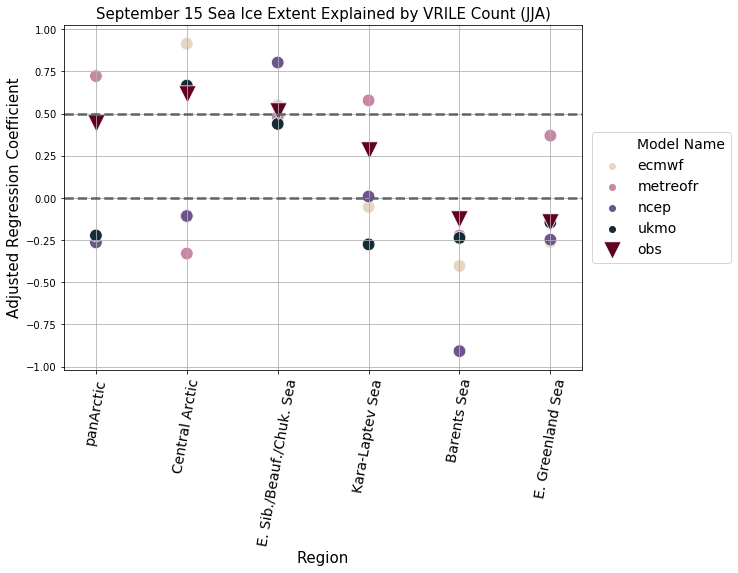

In [38]:
fig1 = plt.figure(1)
ax1 = fig1.add_axes([0,0,1.2,1.2])
ax1a = sns.scatterplot(x='Region',y='R2',hue='Model Name',data=model_R2_select,s=160,
                      palette = sns.cubehelix_palette(4,start=-0.7,rot=0.75))#,legend_out=True)
ax1b = sns.scatterplot(x='Region',y='R2',data=obs_R2_select,s=300,marker='v',
                      color='xkcd:burgundy',label='obs')
ax1.grid()
ax1.set_ylabel('Adjusted Regression Coefficient',fontsize=15)
ax1.set_xlabel('Region',fontsize=15)
ax1.set_xticklabels(model_R2_select['Region'].unique().tolist(),rotation=80,fontsize=14)
ax1.axhline(y=0,color='xkcd:slate grey',linestyle='--',linewidth=2.5)
ax1.axhline(y=0.5,color='xkcd:slate grey',linestyle='--',linewidth=2.5)
ax1.set_title('September 15 Sea Ice Extent Explained by VRILE Count ({seas_str})'.format(seas_str=seas_str),fontsize=15)
ax1a.legend(loc='center right',bbox_to_anchor=(1.3,0.5),fontsize=14)
#
fpath_save = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/figures/'
fname_save1 = fpath_save+'REG_COEF_Sept15_SIE_vs_VRILE_Count{seas_str}_vrile_thresh{vrile_thresh}.png'.format(seas_str=seas_str,
vrile_thresh=thresh_str)
fig1.savefig(fname_save1,format='png',dpi=500,bbox_inches='tight')

Same but for corr coef squared

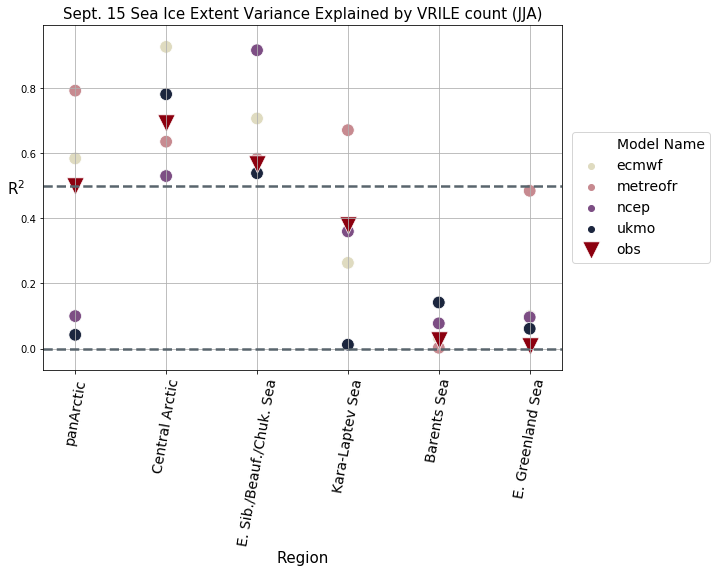

In [39]:
fig2 = plt.figure(2,figsize=(6,4))
ax2 = fig2.add_axes([0,0,1.2,1.2])
ax2a = sns.scatterplot(x='Region',y='corr coef sq',hue='Model Name',data=model_R2_select,s=160,
                      palette = sns.cubehelix_palette(4,start=-0.5,rot=0.75))#,legend_out=True)
ax2b = sns.scatterplot(x='Region',y='corr coef sq',data=obs_R2_select,s=300,marker='v',
                      color='xkcd:crimson',label='obs')
ax2.grid()
ax2.set_ylabel('R$^2$',fontsize=15,rotation=0)
ax2.set_xlabel('Region',fontsize=15)
ax2.set_xticklabels(model_R2_select['Region'].unique().tolist(),rotation=80,fontsize=14)
ax2.axhline(y=0,color='xkcd:slate grey',linestyle='--',linewidth=2.5)
ax2.axhline(y=0.5,color='xkcd:slate grey',linestyle='--',linewidth=2.5)
ax2.set_title('Sept. 15 Sea Ice Extent Variance Explained by VRILE count ({seas_str})'.format(seas_str=seas_str),fontsize=15)
ax2a.legend(loc='center right',bbox_to_anchor=(1.3,0.5),fontsize=14)
fname_save2 = fpath_save+'CORR_COEF_Sept15_SIE_vs_VRILE_Count{seas_str}_vrile_thresh{vrile_thresh}.png'.format(seas_str=seas_str,
vrile_thresh=thresh_str)
fig2.savefig(fname_save2,format='png',dpi=500,bbox_inches='tight')

Same as fig2 but for obs only

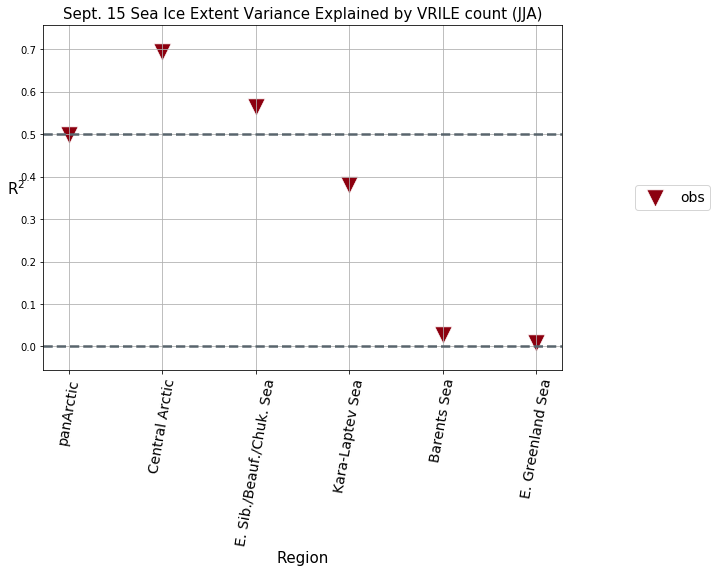

In [40]:
fig3 = plt.figure(3,figsize=(6,4))
ax3 = fig3.add_axes([0,0,1.2,1.2])
#ax2a = sns.scatterplot(x='Region',y='corr coef sq',hue='Model Name',data=model_R2_select,s=160,
#                      palette = sns.cubehelix_palette(4,start=-0.5,rot=0.75))#,legend_out=True)
ax3b = sns.scatterplot(x='Region',y='corr coef sq',data=obs_R2_select,s=300,marker='v',
                      color='xkcd:crimson',label='obs')
ax3.grid()
ax3.set_ylabel('R$^2$',fontsize=15,rotation=0)
ax3.set_xlabel('Region',fontsize=15)
ax3.set_xticklabels(model_R2_select['Region'].unique().tolist(),rotation=80,fontsize=14)
ax3.axhline(y=0,color='xkcd:slate grey',linestyle='--',linewidth=2.5)
ax3.axhline(y=0.5,color='xkcd:slate grey',linestyle='--',linewidth=2.5)
ax3.set_title('Sept. 15 Sea Ice Extent Variance Explained by VRILE count ({seas_str})'.format(seas_str=seas_str),fontsize=15)
ax3b.legend(loc='center right',bbox_to_anchor=(1.3,0.5),fontsize=14)
fname_save3 = fpath_save+'CORR_COEF_OBS_ONLY_Sept15_SIE_vs_VRILE_Count{seas_str}_vrile_thresh{vrile_thresh}.png'.format(seas_str=seas_str,
vrile_thresh=thresh_str)
fig3.savefig(fname_save3,format='png',dpi=500,bbox_inches='tight')